изучение фичей

In [1]:
import sys
import pathlib
cwd = pathlib.Path().cwd()
sys.path.append(cwd.parent.as_posix())
data_folder = cwd.parent.joinpath('data')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd

from dask.distributed import Client, wait
from auxiliary import trim_memory

from dask_ml.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
client = Client(n_workers=1)
client

2022-05-31 04:11:55,033 - distributed.diskutils - INFO - Found stale lock file and directory '/home/avagadro/projects/gb_megafon/research/dask-worker-space/worker-5y4b39np', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 8,Total memory: 15.59 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44965,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.59 GiB
Comm: tcp://127.0.0.1:33021,Total threads: 8
Dashboard: http://127.0.0.1:42439/status,Memory: 15.59 GiB
Nanny: tcp://127.0.0.1:43937,


## compress features

In [3]:
blocksize = '200MB'
drop_feats = ['75', '81', '85', '139', '203']

feats_csv = dd.read_csv(data_folder.joinpath('features.csv'), sep='\t', blocksize=blocksize).drop(['Unnamed: 0', *drop_feats], axis=1)
feats_csv.head()

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,-53.216097,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,25.183903,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,-65.076097,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,2027465,1533502800,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,-65.076097,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0


In [4]:
# push dask data to the cluster separately
features = client.scatter(feats_csv.drop(['id', 'buy_time'], axis=1))
headers = client.scatter(feats_csv[['id', 'buy_time']])

# recast to dask array with computes sizes
dask_array = client.submit(dd.DataFrame.to_dask_array, features, lengths=True, key='recast_to_dask_array')

wait([features, headers, dask_array])

DoneAndNotDoneFutures(done={<Future: finished, type: dask.array.core.Array, key: recast_to_dask_array>, <Future: finished, type: dask.dataframe.core.DataFrame, key: DataFrame-c8a74d16599f58a0a6b9b74309482e0d>, <Future: finished, type: dask.dataframe.core.DataFrame, key: DataFrame-280cc833ca1ae6f46a7272441800be8d>}, not_done=set())

In [5]:
# fit PCA
fit_pca = client.submit(PCA(3).fit, dask_array, key='fit_pca')
wait(fit_pca)

2022-05-31 04:18:26,755 - distributed.worker_memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 12.51 GiB -- Worker memory limit: 15.59 GiB
2022-05-31 04:18:28,125 - distributed.worker_memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 12.44 GiB -- Worker memory limit: 15.59 GiB
2022-05-31 04:18:28,574 - distributed.worker_memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 12.70 GiB -- Worker memory limit: 15.59 GiB
2022-05-31 04:18:45,026 - distributed.worker_memory - WARNING - Worker is at 39% memory usage. Resuming worker. Process memory: 6.22 GiB -- Worker memory limit: 15.59 GiB


DoneAndNotDoneFutures(done={<Future: finished, type: dask_ml.decomposition.pca.PCA, key: fit_pca>}, not_done=set())

In [6]:
calc_feats = client.submit(lambda pca, arr: pca.transform(arr).compute(), fit_pca, dask_array, key='compress_features')
values = calc_feats.result()
wait(calc_feats)

DoneAndNotDoneFutures(done={<Future: finished, type: numpy.ndarray, key: compress_features>}, not_done=set())

In [9]:
# collect compressed features
compressed = client.submit(headers.result().compute, key='compute_headers').result()
compressed[np.arange(3)] = values
# compressed.to_csv(data_folder.joinpath('DASK_compressed_features.csv'), index=False)

## analyse

In [11]:
feats = pd.read_csv(data_folder.joinpath('compressed_features.csv'), usecols=['0', '1', '2'])
# feats = pd.DataFrame(values, columns=[f'{n}' for n in range(values.shape[1])])

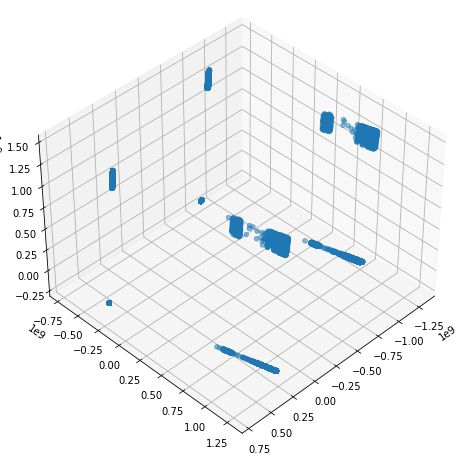

In [18]:
sample = feats.sample(frac=0.1, random_state=7)    # plot only 10% of data

fig = plt.figure(figsize=(14, 8))
ax = plt.axes(projection='3d')
ax.view_init(elev=40, azim=45)
ax.scatter(sample['0'].T, sample['1'].T, sample['2'].T, alpha=0.5);

Сжатые фичи можно визуально разделить на 8 кластеров

In [13]:
# fit KMeans
kmeans = KMeans(n_clusters=8).fit(values)

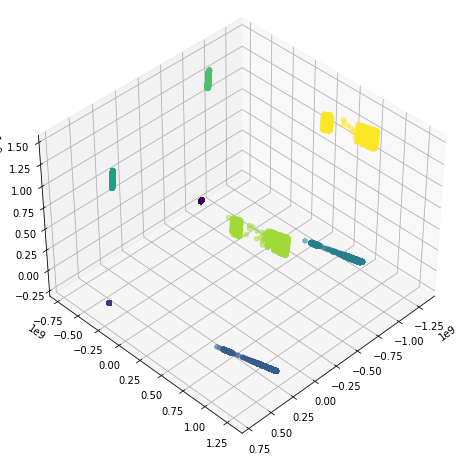

In [19]:
sample = feats.sample(frac=0.1, random_state=7)    # plot only 10% of data

fig = plt.figure(figsize=(14, 8))
ax = plt.axes(projection='3d')
ax.view_init(elev=40, azim=45)
ax.scatter(sample['0'].T, sample['1'].T, sample['2'].T, c=kmeans.labels_[sample.index], alpha=0.5);

In [15]:
#